In [703]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Exercise 1: FFT Gravity Solver 

In [730]:
# Gravitational constant
G = 1 
# Box parameters
ncells = 32
length = 1
radius = 0.1
density = 1

## a) 3D Box

In [708]:
def distr(ncells, length, radius, density):
    half = length/2
    x = np.linspace(-half,half, ncells)
    y = np.linspace(-half,half, ncells)
    z = np.linspace(-half,half, ncells)
    
    sphere = np.zeros((ncells, ncells, ncells))
    for i in range(ncells):
        for j in range(ncells):
            for k in range(ncells):
                r = np.linalg.norm([x[i],y[j],z[k]])
                if r <= radius:
                    sphere[i,j,k] = 1
                    
    mass = 4/3*np.pi*density*radius**3
    
    return sphere*mass/np.sum(sphere)

## b) Analytical solution

In [705]:
def ana_pot(ncells, length, radius, density):
    half = length/2
    x = np.linspace(-half,half, ncells)
    y = np.linspace(-half,half, ncells)
    z = np.linspace(-half,half, ncells)
    
    phi_ana = np.zeros((ncells, ncells, ncells))
    mass = 4/3*np.pi*radius**3*density
    #print(mass)
    
    for i in range(ncells):
        for j in range(ncells):
            for k in range(ncells):
                r = np.linalg.norm([x[i],y[j],z[k]])
                if r > radius:
                    phi_ana[i,j,k] = -G*mass/r
                else:
                    phi_ana[i,j,k] = G*mass/(2*radius)*(r**2/radius**2-3)
                    
    return phi_ana

In [706]:
phi_ana = ana_pot(ncells, length, radius, density)

0.004188790204786391


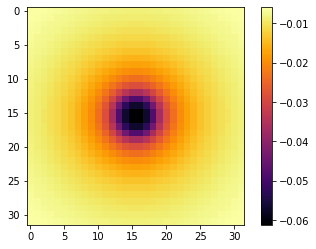

In [707]:
plt.imshow(phi_ana[int(ncells/2)], cmap="inferno")

plt.colorbar()

## c) Numerical solution

In [709]:
def potential(distribution, ncells):
    delta = length/ncells 
    rho_tilde = np.fft.fftn(distribution)
    phi_tilde = np.zeros((ncells,ncells,ncells))
    cosines = [np.sin(np.pi*i/ncells)**2 for i in range(ncells)]
    
    for i in range(ncells):
        for j in range(ncells):
            for k in range(ncells):
                # Replace singularity at phi_tilde(0,0,0)
                if i==0 and j==0 and k==0:
                    phi_tilde[i,j,k] = -4*np.pi*G*rho_tilde[0,0,0]
                else:
                    phi_tilde[i,j,k]= -4*np.pi*G*rho_tilde[i,j,k]*delta**2 / (4*(cosines[i]+cosines[j]+cosines[k]))
                    
    phi = np.real(np.fft.ifftn(phi_tilde))
    return phi

In [710]:
distribution = distr(ncells, length, radius, density)
phi = potential(distribution, ncells)

0.004188790204786391


/home/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/home/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


-1.506133132507739e-06 -1.505335009054578e-06


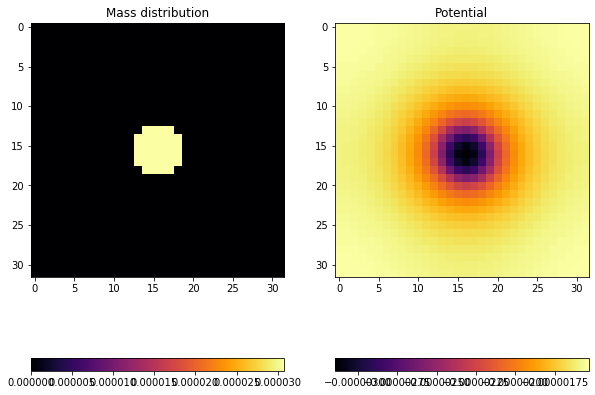

In [711]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax0 = ax[0].imshow(distribution[int(ncells/2)], cmap="inferno")
plt.colorbar(ax0, ax=ax[0],orientation="horizontal")
ax[0].set_title("Mass distribution")

ax1 = ax[1].imshow(phi[int(ncells/2)], cmap="inferno")
plt.colorbar(ax1, ax=ax[1],orientation="horizontal")
ax[1].set_title("Potential")
#ax[0].set_colorbar()
#phi[0,0,0] = 1e60
print(phi[-1,-1,-1], phi[0,0,0])

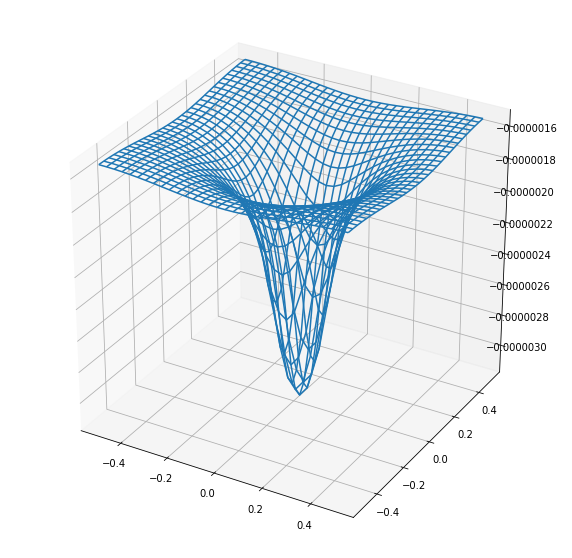

In [712]:
half = length/2
x = np.linspace(-half,half, ncells)
y = np.linspace(-half,half, ncells)

X, Y = np.meshgrid(x, y)
# Create figure
fig=plt.figure(figsize=(10,10))
# Create 3D axes
ax=fig.add_subplot(111,projection="3d")
ax.plot_wireframe(X, Y, phi[int(ncells/2)])

## d) Error analysis

In [713]:
def error(x,y):
    N = np.prod(x.shape)
    e = 1/N*np.sum(np.abs(x-y))
    return e

In [714]:
print(error(phi, phi_ana))

0.009610780638157752


In [715]:
Ns = [50,60,70,80,90,100]
dis = [distr(ncells, length, radius, density) for ncells in Ns]
pots = [potential(dist,ncells) for dist, ncells in zip(dis, Ns)]
pots_ana = [ana_pot(ncells, length, radius, density) for ncells in Ns]
errors = [error(pot, pot_ana) for pot, pot_ana in zip(pots, pots_ana)]
print(errors)

/home/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/home/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


0.004188790204786391
0.004188790204786391
0.004188790204786391
0.004188790204786391
0.004188790204786391
0.004188790204786391
[0.009721149946943754, 0.009753795659075169, 0.009777096668333167, 0.009794571876741223, 0.00980816486130414, 0.009819038544691351]


Text(0, 0.5, '$L_1$-error')

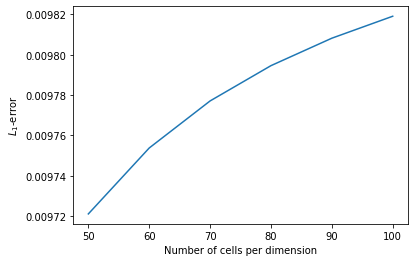

In [718]:
plt.plot(Ns,errors)
plt.xlabel("Number of cells per dimension")
plt.ylabel("$L_1$-error")

As expected, the error scales rougly with $\mathcal{O}(N\log N)$

# Exercise 2: Shock Waves 

## a)

$P(\tau)=\frac{-P_1(\tau_1+\tau)\frac{(\gamma-1)\tau}{2\gamma}-\frac{P_1\tau}{\tau_1}}{1-\frac{(\gamma-1)\tau}{2\gamma}(\tau_1+\tau)}$

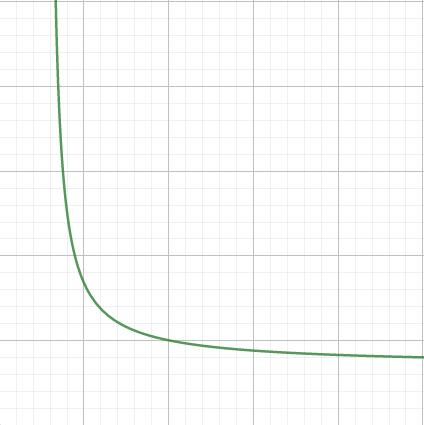

In [734]:
from IPython.display import Image
Image('plot.png')

## b)

This function diverges for $\tau=gamma$, this means the upstream velocity is restricted

## c)

Those are the mechanically as well as thermodynamically allowed post-shock states:
- Above O: strong detonations
- O-A: weak detonations 
- A'-O': weak deflagrations 
- Below O': strong deflagrations